In [3]:
import jax.numpy as np
import tree_math
import dataclasses

from jaxsnn.base import funcutils
from jaxsnn.base import implicit
from jaxsnn.tree_solver import ArrayLike, tree_solve, tree_matmul

In [202]:
@tree_math.struct
class HodgekinHuxleyState:
    v: ArrayLike
    m: ArrayLike
    h: ArrayLike
    n: ArrayLike

@tree_math.struct
class HodgekinHuxleyParameters:
    g_K: ArrayLike
    E_K: ArrayLike
    g_Na: ArrayLike
    E_Na: ArrayLike
    g_L: ArrayLike
    E_L: ArrayLike
    C_m_inv: ArrayLike


def alpha_n(v):
    x = (0.02 * (v - 25))
    y = (1 - np.exp(-(v-25)/9))
    return x/y

def alpha_m(v):
    x = 0.182 * (v + 35)
    y = (1 - np.exp(-(v+35)/9.0))
    return x/y

def alpha_h(v):
    return 0.25 * np.exp(-(v+90)/12.0)

def beta_n(v):
    x = -0.002 * (v - 25)
    y = 1 - np.exp((v - 25) / 9.0)
    return x/y

def beta_m(v):
    x = -0.002 * (v - 25)
    y = 1 - np.exp((v-25)/9)
    return x/y

def beta_h(v):
    return 0.25 * np.exp((v+62)/6.0)/np.exp((v+90)/12.0)

def I_Na(s : HodgekinHuxleyState, p : HodgekinHuxleyParameters):
    return p.g_Na * s.m**3 * s.h * (s.v - p.E_Na)

def I_K(s : HodgekinHuxleyState, p: HodgekinHuxleyParameters):
    return p.g_K * s.n**4 * (s.v - p.E_K)

def I_L(s : HodgekinHuxleyState, p: HodgekinHuxleyParameters):
    return p.g_L * (s.v - p.E_L)

def channel_dynamics(alpha, beta):
    def dynamics(x : ArrayLike, v : ArrayLike):
        return alpha(v) * (1 - x) - beta(v) * x
    return dynamics

def hodgekin_huxley_dynamics(p : HodgekinHuxleyParameters):
    m_dynamics = channel_dynamics(alpha_m, beta_m)
    h_dynamics = channel_dynamics(alpha_h, beta_h)
    n_dynamics = channel_dynamics(alpha_n, beta_n)

    def dynamics(s : HodgekinHuxleyState, I_in : ArrayLike):
        return HodgekinHuxleyState(
            p.C_m_inv * (-I_K(s, p) - I_Na(s, p) - I_L(s, p) + I_in),
            m_dynamics(s.m, s.v),
            n_dynamics(s.n, s.v),
            h_dynamics(s.h, s.v)
        )
    return dynamics

$$
\alpha(v) (1 - x) - \beta(v) x = -\frac{1}{\tau_x(v)} (x - x_0(v))
$$

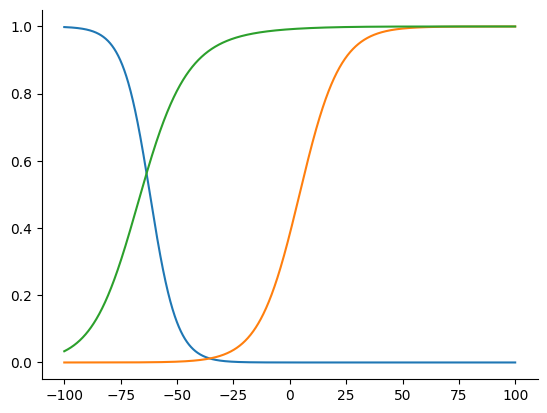

In [204]:
import matplotlib.pyplot as plt

def x0(alpha, beta):
    def x0(v):
        return alpha(v)/(alpha(v) + beta(v))
    return x0

h0 = x0(alpha_h, beta_h)
n0 = x0(alpha_n, beta_n)
m0 = x0(alpha_m, beta_m)

vs = np.arange(-100, 100, 0.1)
plt.plot(vs, h0(vs))
plt.plot(vs, n0(vs))
plt.plot(vs, m0(vs))

In [216]:
p = HodgekinHuxleyParameters(
    g_K = 35.0,    # Average potassium channel conductance per unit area (mS/cm^2)
    g_Na = 40.0,   # Average sodoum channel conductance per unit area (mS/cm^2)
    g_L = 0.3,     # Average leak channel conductance per unit area (mS/cm^2)
    C_m_inv = 1.0, # Inverse Membrane capacitance per unit area (cm^2/uF)
    E_K = -77.0,     # Potassium potential (mV)
    E_Na = 55.0,   # Sodium potential (mV)
    E_L = -65.0,   # Leak potential (mV)
)

In [217]:
from jaxsnn.base import explicit

def projection(x, u):
    return x
def output(x,u):
    return x

dynamics = hodgekin_huxley_dynamics(p)

equation = explicit.ExplicitConstrainedCDE(
   explicit_terms=dynamics,
   projection=projection,
   output=output
)

In [231]:
import numpy as onp

initial_state = HodgekinHuxleyState(
    v = p.E_L,
    m = m0(p.E_L),
    n = n0(p.E_L),
    h = h0(p.E_L)
)

dt = 0.01
step_fn = explicit.classic_rk4_cde(equation, dt)
stim = onp.zeros(25000)
stim[7000:13000] = 50  # add a square pulse


integrator = funcutils.controlled_trajectory(step_fn, stim)
e, actual = integrator(initial_state)

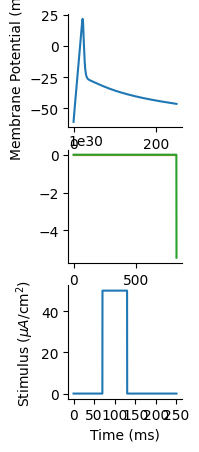

In [232]:
import matplotlib as mpl

# remove top and right axis from plots
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

fig, ax = plt.subplots(3, figsize=(5*2, 5), subplot_kw=dict(box_aspect=1))

ts = np.arange(0,250,dt)
ax[0].set_ylabel('Membrane Potential (mV)')
ax[0].plot(np.arange(0,250), actual.v[:250])
ax[1].plot(actual.m)
ax[1].plot(actual.h)
ax[1].plot(actual.n)
ax[2].plot(ts, stim)
ax[2].set_ylabel('Stimulus ($\mu A/\mathrm{cm}^2$)')
ax[2].set_xlabel('Time (ms)')
ax[2].set_xticks([0,50,100,150,200,250])

fig.savefig('figures/hodgekin_huxley_example.png', dpi=300)